In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import pytz

In [2]:
# Load the dataset
data = pd.read_csv('SensorDataLTM.csv')

In [3]:
# Convert SensingDateTime(Hour) to datetime format
data['SensingDateTime(Hour)'] = pd.to_datetime(data['SensingDateTime(Hour)'], utc=True)


In [4]:
# Define the AEST timezone
aest = pytz.timezone('Australia/Sydney')

# Convert the datetime to AEST
data['SensingDateTime(Hour)'] = data['SensingDateTime(Hour)'].dt.tz_convert(aest)

In [5]:
# Extract useful components from the AEST datetime column
data['Year'] = data['SensingDateTime(Hour)'].dt.year
data['Month'] = data['SensingDateTime(Hour)'].dt.month
data['Day'] = data['SensingDateTime(Hour)'].dt.day
data['Hour'] = data['SensingDateTime(Hour)'].dt.hour
data['DayOfWeek'] = data['SensingDateTime(Hour)'].dt.dayofweek


In [6]:
# Set the datetime index for the time series decomposition with AEST
data.set_index('SensingDateTime(Hour)', inplace=True)


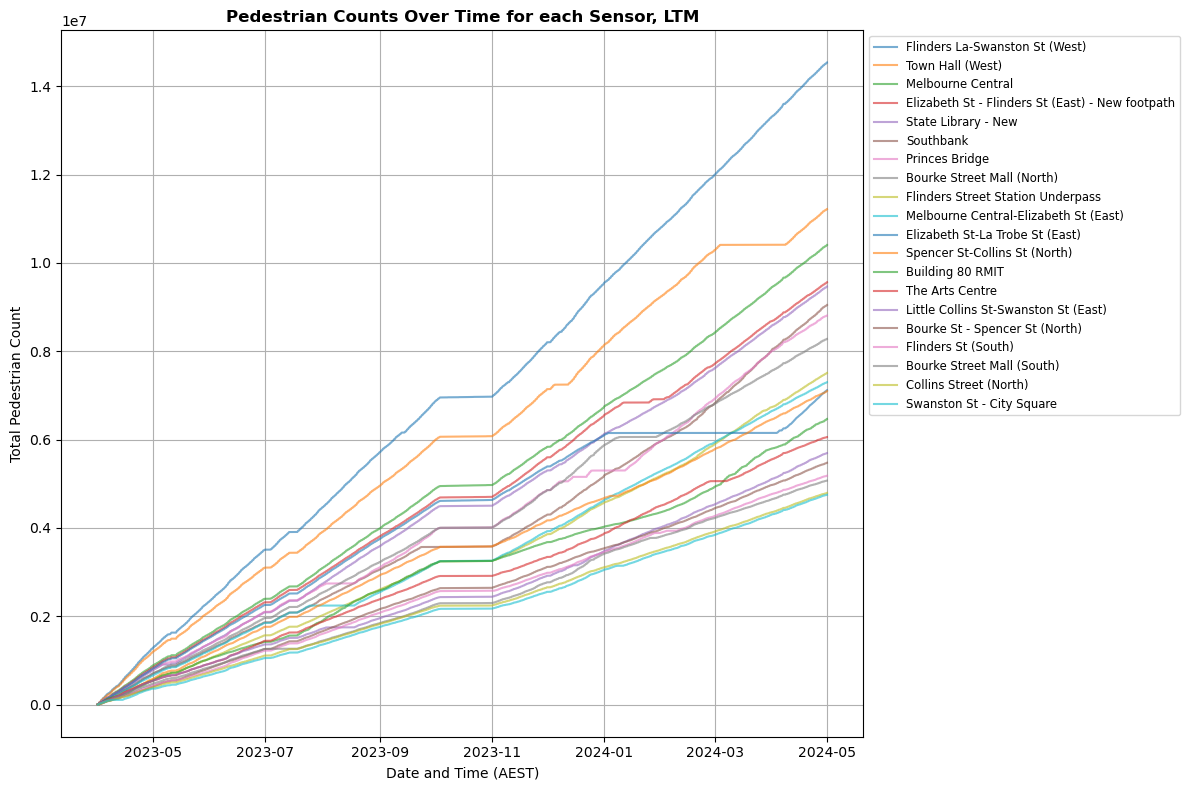

In [16]:
import numpy as np
from scipy.stats import linregress

# Identify the top 20 sensors by total pedestrian counts
top_20_sensors = data.groupby('Sensor_Description')['Total_of_Directions'].sum().nlargest(20).index


# Create a figure for the cumulative plot
plt.figure(figsize=(12, 8))

# Plot cumulative pedestrian counts and trend lines for each of the top 20 sensors
for sensor in top_20_sensors:
    sensor_data = data[data['Sensor_Description'] == sensor]
    time_series_aest = sensor_data['Total_of_Directions'].resample('H').sum().cumsum()


    # Plot the time series and the trend line
    plt.plot(time_series_aest.index, time_series_aest, alpha=0.6, label=f'{sensor}')
    #plt.plot(forecast_index, forecast.cumsum() + time_series_aest.iloc[-1], linestyle=':', label=f'{sensor} Forecast')
    #plt.plot(time_series_aest.index, trend_line, label=f'{sensor} Trend Line')

# Set labels and title
plt.xlabel('Date and Time (AEST)')
plt.ylabel('Total Pedestrian Count')
plt.title('Pedestrian Counts Over Time for each Sensor, LTM',weight='bold')
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fontsize = 'small')  # Adjust legend to be outside the plot
plt.tight_layout()

# Show the plot
plt.show()

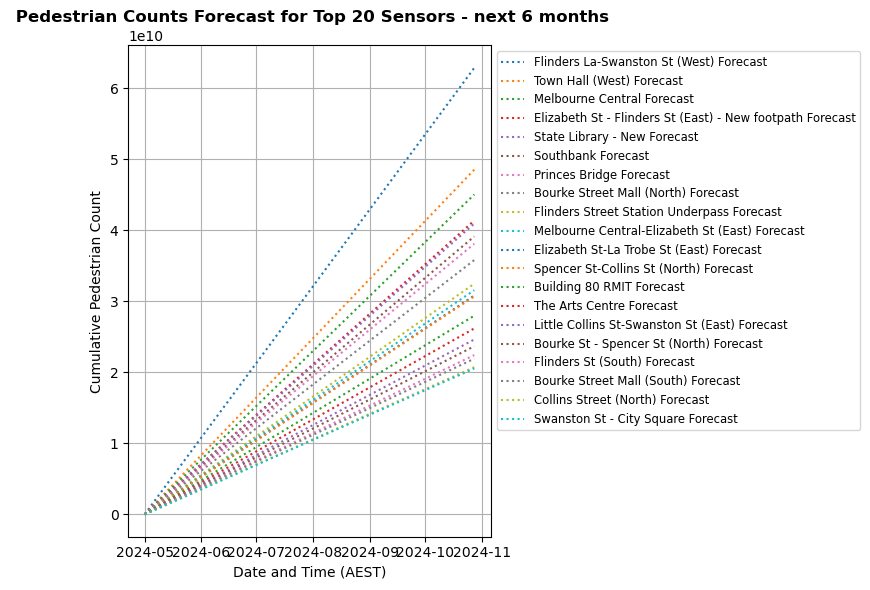

In [22]:
import numpy as np
from scipy.stats import linregress

# Identify the top 20 sensors by total pedestrian counts
top_20_sensors = data.groupby('Sensor_Description')['Total_of_Directions'].sum().nlargest(20).index


# Create a figure for the cumulative plot
plt.figure(figsize=(8, 6))

# Plot cumulative pedestrian counts and trend lines for each of the top 20 sensors
for sensor in top_20_sensors:
    sensor_data = data[data['Sensor_Description'] == sensor]
    time_series_aest = sensor_data['Total_of_Directions'].resample('H').sum().cumsum()
    
     # Fit an ARIMA model and forecast the next 3 months (assuming hourly data)
    model = ARIMA(time_series_aest, order=(1, 1, 1))
    model_fit = model.fit()
    forecast_steps = 6 * 30 * 24  # 6 months of hourly data
    forecast = model_fit.forecast(steps=forecast_steps)
    
    # Create forecast index
    forecast_index = pd.date_range(start=time_series_aest.index[-1], periods=forecast_steps + 1, freq='H')[1:]

    # Plot the time series and the trend line
    #plt.plot(time_series_aest.index, time_series_aest, alpha=0.6, label=f'{sensor} Counts')
    plt.plot(forecast_index, forecast.cumsum() + time_series_aest.iloc[-1], linestyle=':', label=f'{sensor} Forecast')
    #plt.plot(time_series_aest.index, trend_line, label=f'{sensor} Trend Line')

# Set labels and title
plt.xlabel('Date and Time (AEST)')
plt.ylabel('Cumulative Pedestrian Count')
plt.title(' Pedestrian Counts Forecast for Top 20 Sensors - next 6 months',weight = "bold")
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1,fontsize="small")  # Adjust legend to be outside the plot
plt.tight_layout()

# Show the plot
plt.show()

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Initialize lists to store performance metrics
mae_list = []
mse_list = []
mape_list = []

# Iterate over each of the top 20 sensors
for sensor in top_20_sensors:
    sensor_data = data[data['Sensor_Description'] == sensor]
    time_series_aest = sensor_data['Total_of_Directions'].resample('H').sum().cumsum()
    
    # Split the data into training and testing sets (80-20 split)
    train_size = int(len(time_series_aest) * 0.8)
    train, test = time_series_aest[:train_size], time_series_aest[train_size:]
    
    # Fit an ARIMA model on the training set
    model = ARIMA(train, order=(1, 1, 1))
    model_fit = model.fit()
    
    # Forecast the values for the test set period
    forecast = model_fit.forecast(steps=len(test))
    
    # Calculate performance metrics
    mae = mean_absolute_error(test, forecast)
    mse = mean_squared_error(test, forecast)
    mape = mean_absolute_percentage_error(test, forecast)
    
    mae_list.append(mae)
    mse_list.append(mse)
    mape_list.append(mape)

# Print performance metrics
print(f"Mean Absolute Error (MAE): {np.mean(mae_list)}")
print(f"Mean Squared Error (MSE): {np.mean(mse_list)}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(np.mean(mse_list))}")
print(f"Mean Absolute Percentage Error (MAPE): {np.mean(mape_list)}%")


Mean Absolute Error (MAE): 886337.7241613636
Mean Squared Error (MSE): 1216093779388.4592
Root Mean Squared Error (RMSE): 1102766.4210468412
Mean Absolute Percentage Error (MAPE): 12.67502701450613%
